In [42]:
import pandas as pd
import numpy as np
import sklearn

In [43]:
 import matplotlib.pyplot as plt

In [44]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [45]:
from sklearn.preprocessing import MinMaxScaler

In [46]:
import seaborn as sns
%matplotlib inline

In [47]:
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio

In [48]:
customers = pd.read_csv("customers.csv")

In [49]:
customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [53]:
X = customers.iloc[:, 1:]

In [62]:
X.Gender = X.Gender.apply(lambda x: 0 if x == "Male" else 1)

In [11]:
scaler = MinMaxScaler()

In [12]:
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [13]:
X_fit = scaler.transform(X)

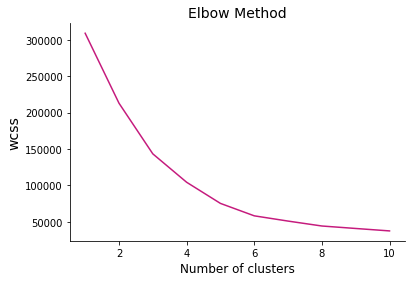

In [64]:
wcss = []
for i in range(1,11):
    km = KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss, c="#c51b7d")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Elbow Method', size=14)
plt.xlabel('Number of clusters', size=12)
plt.ylabel('wcss', size=14)
plt.show() 

In [70]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=10, n_init=10, random_state=0)

y_means = kmeans.fit_predict(X)

In [71]:
pca = PCA(n_components=2).fit(X)

In [72]:
pca_2d = pca.transform(X)

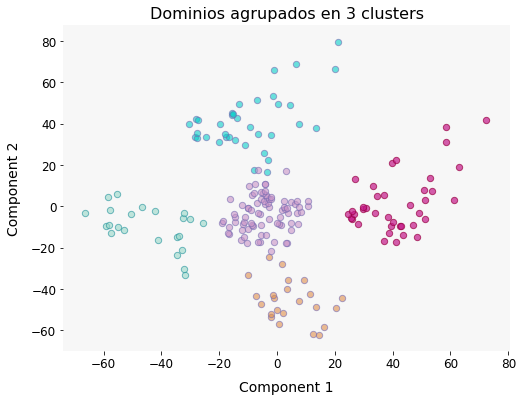

In [74]:
fig, ax = plt.subplots(figsize = (8, 6))

for i in range(0, pca_2d.shape[0]):
    if y_means[i] == 0:
        c1 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c="#99d8c9", s=40, edgecolors="#1c9099", alpha=0.6)
    elif y_means[i] == 1:
        c2 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c="#c51b8a", s=40, edgecolors="#980043", alpha=0.7)
    elif y_means[i] == 2:
        c3 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c="#c994c7", s=40, edgecolors="#756bb1", alpha=0.6)
    elif y_means[i] == 3:    
        c4 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c="#0bd0cb", s=40, edgecolors="#756bb1", alpha=0.6)
    elif y_means[i] == 4:
        c5 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c="#e0904e", s=40, edgecolors="#756bb1", alpha=0.6)
        
        
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.xticks(size=12)
plt.yticks(size=12)

plt.xlabel("Component 1", size = 14, labelpad=10)
plt.ylabel("Component 2", size = 14, labelpad=10)

plt.title('Dominios agrupados en 3 clusters', size=16)

ax.set_facecolor("#f7f7f7")

plt.show()

In [75]:
x = []
y = []
z = []
for i in range(0, pca_2d.shape[0]):
    x.append(pca_2d[i,0])
    y.append(pca_2d[i,1])
    z.append(i)

In [76]:
labels = [customers["CustomerID"][i] for i in range(customers.shape[0])]

In [77]:
N = len(x)
colors = np.random.rand(N)*20
sz = np.random.rand(N)*30
#colors = [abs(j)*20 for j in x]
#sz = np.random.rand(N)*30


init_notebook_mode(connected=True)



data = [
    go.Scatter(
        x=x,
        y=y,
        mode='markers',
        text=labels,
        marker={'size': sz,
                'color': colors,
                'opacity': 0.6,
                'colorscale': 'Viridis'
                       })
        ]

layout = go.Layout(
    title='Desliza por encima de un punto para ver el dominio'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='my_plot')